Set the working directory and make python find the e3dsecs package

In [1]:
import os
notebook_file_path = os.path.realpath('__file__')
os.chdir(os.path.dirname(notebook_file_path))
import sys
parent_directory = os.path.dirname(notebook_file_path)
e3dsecsdir = os.path.abspath(os.path.join(parent_directory, '..'))
sys.path.append(e3dsecsdir)

Import the packages needed

In [2]:


from e3dsecs import simulation, grid, data, convection, model, diagnostics
import numpy as np
import matplotlib.pyplot as plt
import apexpy
from gemini3d.grid.convert import geog2geomag
import lompe

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


Set various options

In [3]:
path            = '/Users/jone/Documents/uib/gemini_output/'
                       # Adjust to fit your system to find the GEMINI files
maph            = 200  # km, mapping altitude. Ions assumed fully magnetized above this alt.
extend          = 5     # How many padding "frames" used for lompe grid around 3D hor. grid
alt_layers      = np.concatenate((np.arange(90,140,5),np.arange(140,170,10), 
                                    np.arange(170,230,20),np.arange(230,500,50)))
                       # The vertical layers to be used
crop_factor     = 0.2  # How much to reduce the CS grid compared to GEMINI grid
inputmode       = 'vi' # See documentation e.g. in model.py for allowed values. 
                       # Specifies how jperp estimates are obtained
e3doubt_        = True # Wheter to use realistic variances of the observations, and add 
                       # corresponding noise
intsec          = 5*60  # Integrationtime in seconds used in E3DOUBT                       
sitelat         = 67.7# Gegraphic latitude of transmitter site location
sitephi         = 23.0 # Gegraphic longitude of transmitter site location            
min_alt         = 90   # km, start altitude of where to sample along beams
max_alt         = 500  # km, stop altitude of where to sample along beams
dr              = 4    # altitude resolution of sampling
l1_lompe        = 1e-1 # Lompe regularization parameter 1 (model norm)
l2_lompe        = 0    # Lompe regularization parameter 2 (east-west structure)

factop          = False# Provide values of vertical current at top of domain
vert_profile    = None # Regularize vertical Hall and Pedersen profile based on 
                       # GEMINI profile. None or # km from where it is applied above
vert_dprofile   = False# Regularize vertical profile of gradient of H/P currents 
                       # based on electron density profile. NOT WORKING
l1              = 10**(-1.5) # Regularization parameter for 3D reconstruction inversion
diagnostic      = False# Wheter to make diagnostic plots
overwrite       = False# Overwrites exisring 3D model coefficient file
crossval        = False# Determine 3D model reg. parameter using cross-validation
suff            = '_beamtest' # suffix to add to coef filename to distinguish it
beamfile        = 'datadict_41beams.npy' # Specifies which beam sampling file to use
savefigs        = False# Wheher the figures will be saved

Make objects containing simulation data (sim), grid (gr), sampled data(dat), fitted convection (conv), and the 3d model (mod)

In [4]:
sim = simulation.simulation(path, maph=maph)
gr = grid.grid(sim, alts=alt_layers, extend=extend, dlat=0.3, dlon=0, resolution_factor=0.45, crop_factor=crop_factor)
dat = data.data(gr, sim, beams=True, sitelat=sitelat, sitephi=sitephi,
                 az=None, el=None, uniformmesh=False, lat_ev=None, lon_ev=None, 
                 alt_ev=None, e3doubt_=e3doubt_, intsec = intsec, min_alt=min_alt, 
                 max_alt=max_alt, dr=dr, tempfile=beamfile)
conv = convection.convection(gr.grid_l, dat, inputmode=inputmode, e3doubt_=e3doubt_, l1_lompe=l1_lompe, 
                 l2_lompe=l2_lompe, maph=maph)
mod = model.model(gr, inputmode=inputmode, 
                           factop=factop, vert_profile=vert_profile, 
                           vert_dprofile=vert_dprofile, l1=l1, 
                           diagnostic=diagnostic, overwrite=overwrite, 
                           crossval=crossval, e3doubt_=e3doubt_, suff=suff)

Using existing sampling file with estimated variances from E3DOUBT
saving................. : ['model', 'data_locations', 'efield', 'convection', 'ground_mag', 'electric_current', 'space_mag_fac', 'space_mag_full', 'fac', 'hall', 'pedersen', 'secs_current']
Saved Lompe file.
Model coef file exists


Do the 3D inversion

In [5]:
if not mod.file_exists or overwrite:
    mod.run_inversion(gr, conv, sim)

### Analysis of performance  
Load inversion results. To save time, we reload the inversion file here, so that the inversion above dont have to be called

In [6]:
m_ = np.load(mod.filename, allow_pickle=True).item()
m = m_['m']
if (inputmode=='vi') or (inputmode=='vi_ohmslaw'):
    lmodel = conv.lmodel

Make new evaluation grid that does not contain locations outside 3D grid

In [7]:
alts__ = gr.alts_grid[1:]-gr.altres[1:]
xi_e  = gr.grid.xi[0,1:] - gr.grid.dxi/2 
eta_e = gr.grid.eta[1:,0]- gr.grid.deta/2
alt_ev, eta_ev, xi_ev = np.meshgrid(alts__, eta_e, xi_e, indexing='ij')
lon_ev, lat_ev = gr.grid.projection.cube2geo(xi_ev, eta_ev)  
shape = lon_ev.shape

First, get the true values from GEMINI on the evaluation grid, and compute what the input values to the 3D inversion (jperp) would have been given the lmodel at the evaluating locations, to use for performance evaluation

In [8]:
_data = data.data(gr, sim, beams=False, uniformmesh=True, 
                  lat_ev=lat_ev, lon_ev=lon_ev, alt_ev=alt_ev, 
                  e3doubt_=False)
if not 'phitop' in inputmode:
    vperp = conv.get_E_from_lmodel(sim, _data, returnvperp=True)
    _data.vperp_electron = vperp
inputdict = mod.make_inputdict(_data, gr, inputmode=inputmode, ext_factor=-1, 
                    hp_from_brekke=False)    
d = np.hstack((inputdict['jperp'][2,:], -inputdict['jperp'][1,:], 
               inputdict['jperp'][0,:])) # (r, theta, phi components)

Evaluate the 3D model of current denisty on the uniform evaluation grid

In [9]:
#Make G to evaluate for full j based on the model made above
G = mod.make_G(gr.grid, m_['alts_grid'], lat_ev, lon_ev, alt_ev, ext_factor=0)
full_j = G.dot(m)
#Get the jperp and fac of the ful_j expressed by the model, to be compared to input
br, btheta, bphi = mod.make_b_unitvectors(_data.Bu, 
                -_data.Bn, _data.Be)
N = br.size
B = mod.make_B(br, btheta, bphi)
P = mod.make_P(N)
j_perp = P.T.dot(B.dot(P.dot(full_j)))
jpar = np.sum(np.array([full_j[0:N], full_j[N:2*N], full_j[2*N:3*N]]) * 
                np.array([br, btheta, bphi]), axis=0)

### Scatterplot of reconstruction performance

<class 'e3dsecs.data.data'>


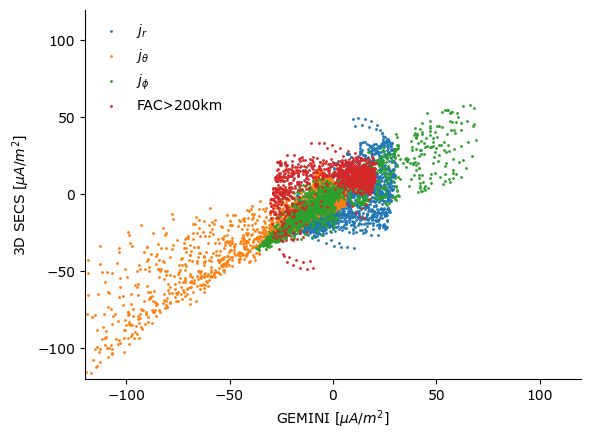

In [10]:
fig = diagnostics.scatterplot_reconstruction(gr.grid, gr.alts_grid, _data, lon_ev.flatten(), \
                                lat_ev.flatten(), alt_ev.flatten(), full_j, jpar, \
                                dipolekw=False, inout=False)
if savefigs:
    fig.savefig('./plots/3d_reconstruction_minimal_scatterplot.pdf', dpi=250,bbox_inches='tight')    


### Slice plot through modelling domain
Also possible to generate gifs of performance in different slices with this function.


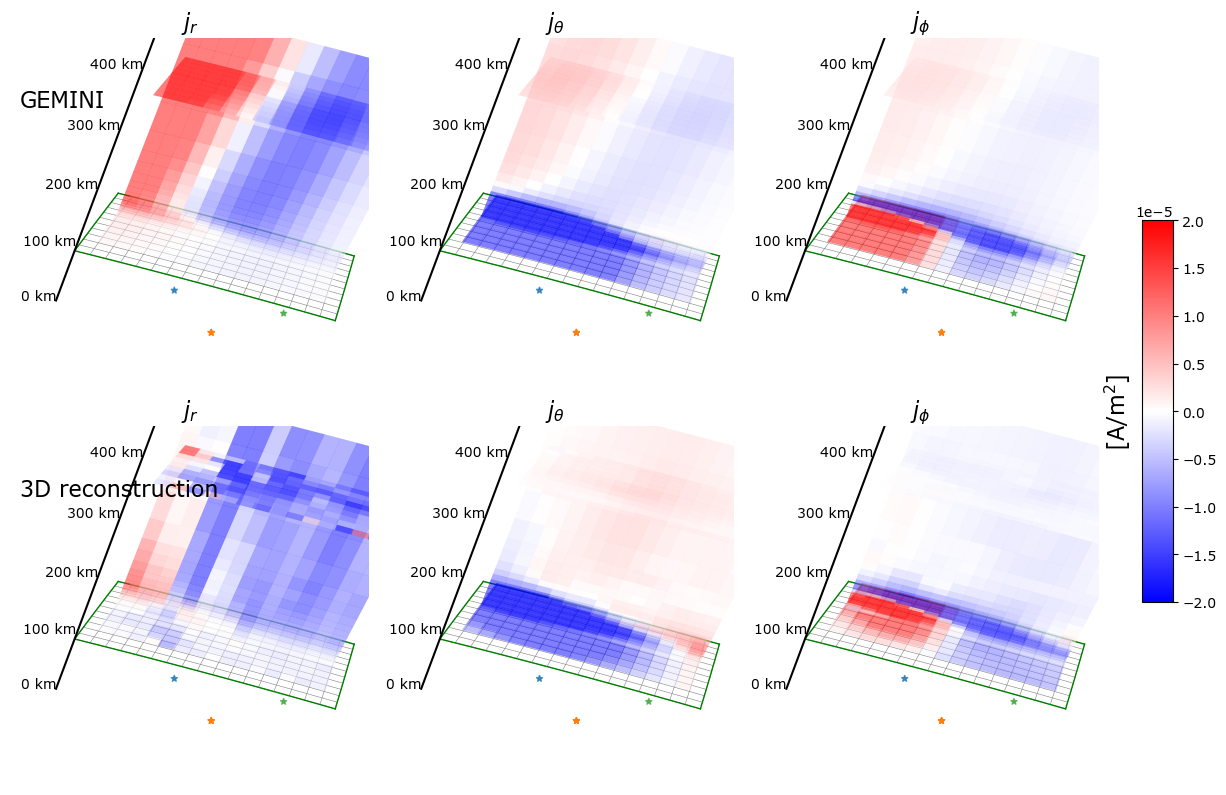

In [11]:
clim = 2e-5
meshgrid = (alt_ev,lat_ev,lon_ev)
fig = diagnostics.performance_plot(full_j, meshgrid, _data, gr.grid, gr.alts_grid, 
                            clim=clim, cut=['j','k','k'], ind=[5,2,18], transmitter=conv.data.transmitter,
                            receivers=conv.data.receivers)
if savefigs:
    fig.savefig('./plots/3d_reconstruction_minimal.pdf', dpi=250,bbox_inches='tight')

Make a plot of the value of the 3dsecs model amplitudes at some cuts

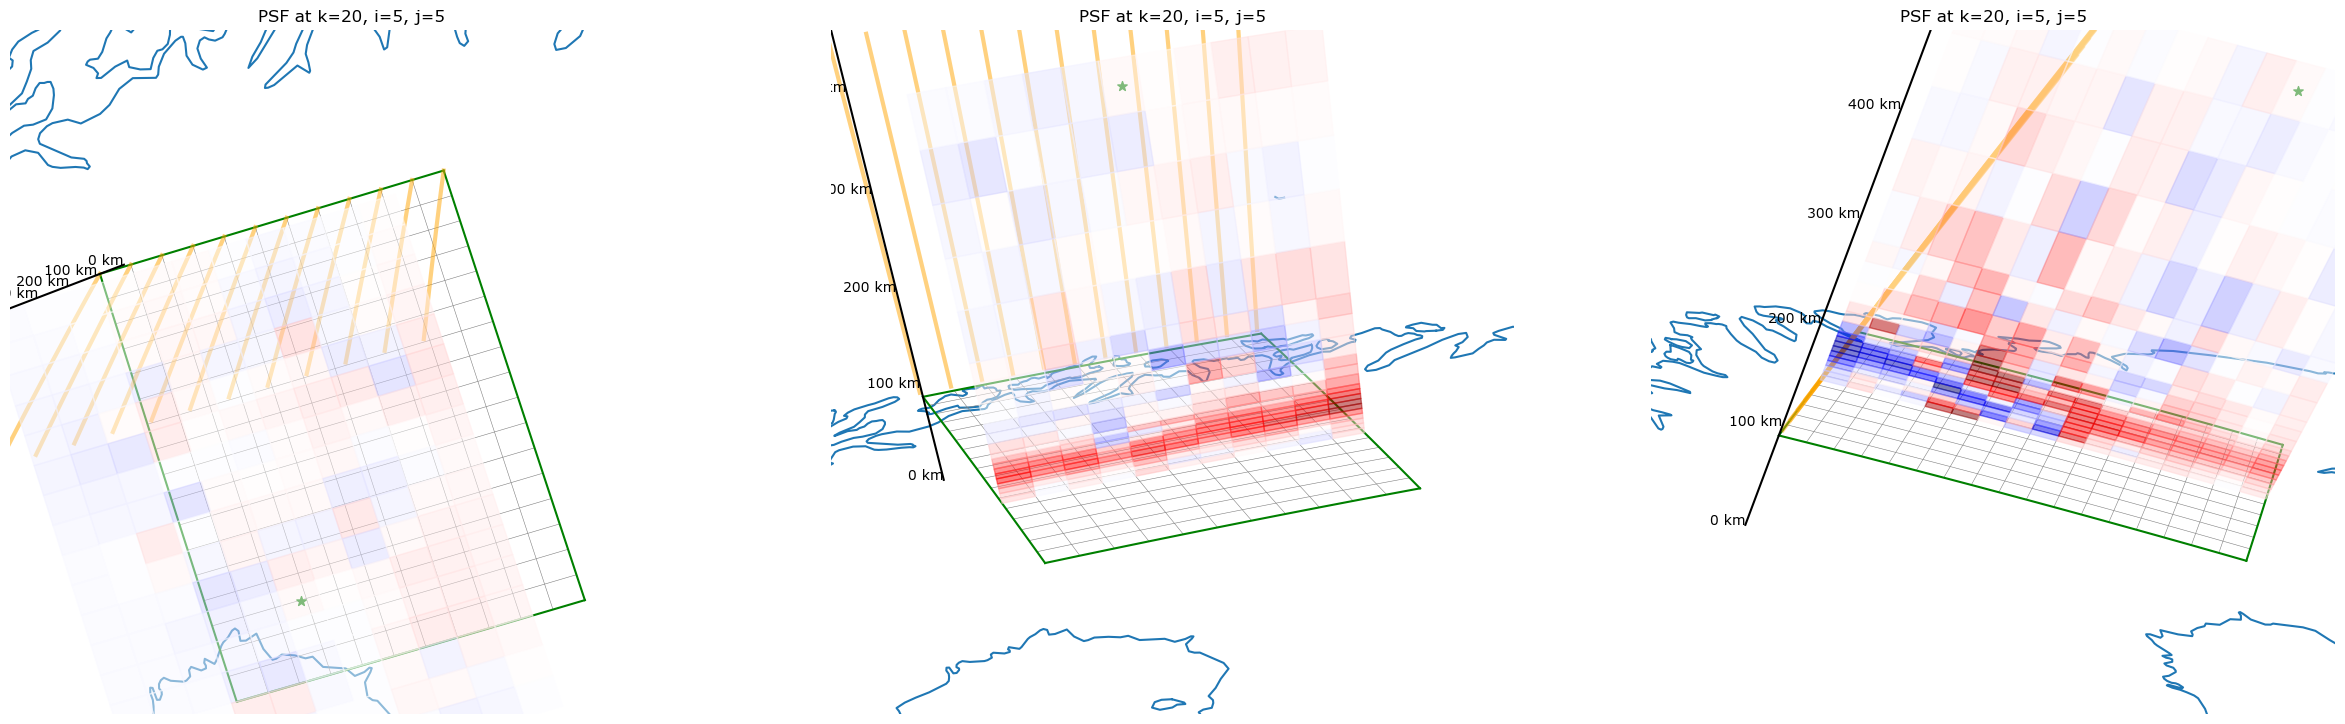

In [12]:
cfdf = 0 #0 for CF, 1 for DF
diagnostics.model_amplitude_analysis(gr.grid, gr.alts_grid, m[cfdf*gr.K*gr.I*gr.J:(cfdf+1)*gr.K*gr.I*gr.J], clim=0.5, 
                                        dipoleB=False, k=20) 

### Make SNR plot of reconstruction

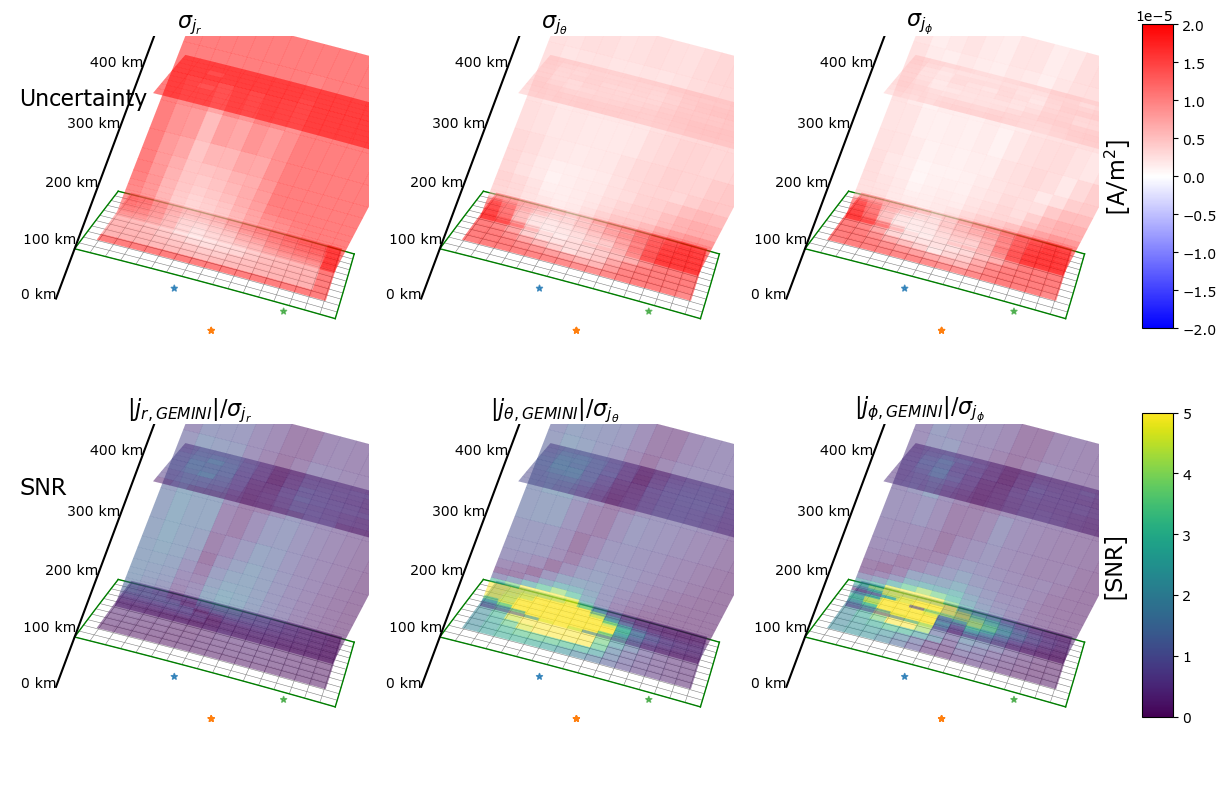

In [13]:
Cmpost = m_['Cmpost']
covar_j = G.dot(Cmpost).dot(G.T) # Nothe the r,theta,phi order
meshgrid = (alt_ev,lat_ev,lon_ev)
fig = diagnostics.snr_output_plot(covar_j, meshgrid, _data, gr.grid, gr.alts_grid, 
                            clim=clim, cut=['j','k','k'], ind=[5,2,18], transmitter=conv.data.transmitter,
                            receivers=conv.data.receivers)
if savefigs:
    fig.savefig('./plots/3d_uncertainty_minimal.pdf',bbox_inches='tight', dpi=300)

### Plot neutral wind field estimates from 3D reconstruction, using conductivities from GEMINI (applying Ohms law)

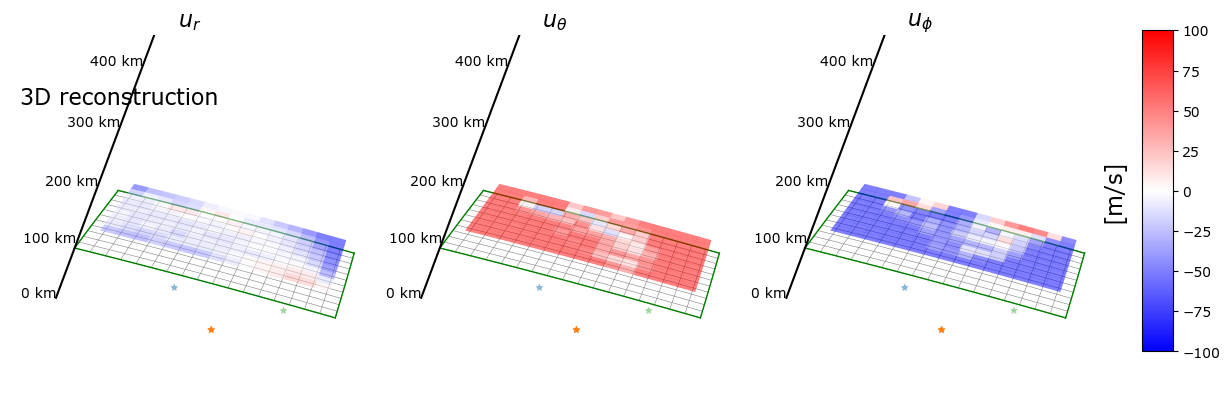

In [14]:
jperp = np.vstack((j_perp[2*N:], -j_perp[N:2*N], j_perp[:N]))
_data = mod.calc_u(_data, conv, sim, jperp)
u = np.hstack((_data.uu, -_data.un, _data.ue))
clim = 100
plot_titles = ['$u_{\phi}$', '$u_{\\theta}$', '$u_{r}$']
unit = '[m/s]'
meshgrid = (alt_ev,lat_ev,lon_ev)
fig = diagnostics.output_plot(u, meshgrid, _data, gr.grid, gr.alts_grid, 
                            clim=clim, cut=['k'], ind=[5], transmitter=conv.data.transmitter,
                            receivers=conv.data.receivers, plot_titles=plot_titles, unit=unit)
if savefigs:
    fig.savefig('./plots/neutral_wind_minimal.pdf',bbox_inches='tight', dpi=300)